In [1]:
from llama_cpp import Llama
import torch

class ModelManager:
    def __init__(self, model_path):
        self.model_path = model_path
        self.model = None
        self.status = 'initializing'
        self.load_model()

    def load_model(self):
        try:
            self.status = 'loading'
            # Use CUDA if available
            n_gpu_layers = -1 if torch.cuda.is_available() else 0
            self.model = Llama(
                model_path=self.model_path,
                n_ctx=2048,
                chat_format=None,
                n_gpu_layers=n_gpu_layers,
                n_threads=8,
                verbose=False,  # Set to True for debugging
            )
            self.status = 'ready'
        except Exception as e:
            self.status = 'failed'
            print(f"Error loading model: {str(e)}")

    def format_prompt(self, messages):
        formatted_prompt = ""
        for message in messages:
            role = message['role']
            content = message['content']
            formatted_prompt += f"<|start_header_id|>{role}<|end_header_id|>\n{content}<|eot_id|>"
        formatted_prompt += "<|start_header_id|>assistant<|end_header_id|>"
        return formatted_prompt

    def inference(self, messages):
        if self.status != 'ready':
            raise Exception("Model is not ready")

        prompt = self.format_prompt(messages)

        try:
            response = self.model(
                prompt,
                max_tokens=300,
                stop=['<|eot_id|>'],
                echo=False,
                grammar=None,
                temperature=0.2,
            )
            return response['choices'][0]['text'].strip()
        except Exception as e:
            raise Exception(f"Error during inference: {str(e)}")

# Initialize the model manager with the path to your GGUF file
model_manager = ModelManager('V5Sherlock8bit.gguf')


## Testing the training set

In [2]:
import json

# Load the JSON file
with open('SherlockDataset2.json', 'r') as file:
    conversations = json.load(file)


In [3]:
def prepare_testing_set(conversations):
    test_data = []
    
    for conversation in conversations:
        # Extract the entire message history except the last "assistant" response
        messages = conversation['messages'][:-1]
        
        # Extract the last "assistant" response as the reference response
        reference_response = conversation['messages'][-1]['content']
        
        # Add the data to the test set
        test_data.append({
            "messages": messages,               # This will be fed to the model
            "reference_response": reference_response  # This is what the model's output will be compared against
        })
    
    return test_data

In [4]:
# Generate the testing set
testing_set = prepare_testing_set(conversations)

# Display the test set for verification
for i, test in enumerate(testing_set):
    print(f"Test Case {i+1}:")
    print("Messages for Model:")
    for msg in test['messages']:
        print(f"{msg['role']}: {msg['content']}")
    print("Reference Response:", test['reference_response'])
    print("-------------")

Test Case 1:
Messages for Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that borders on the fantastic, which you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Hol

### Defining functions for custom LIWC

In [5]:
import nltk
from nltk.corpus import wordnet as wn
from collections import Counter
import re

def generate_word_list_from_wordnet(seed_words):
    """Generate a word list for a category based on seed words using WordNet."""
    word_list = set(seed_words)
    for word in seed_words:
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                word_list.add(lemma.name())
    return list(word_list)

# Expanded seed words for each category
seed_words = {
    "cognitive_processes": [
        "know", "think", "consider", "analyze", "believe", "reason", 
        "deduce", "infer", "conclude", "logic", "assume", "suppose", 
        "surmise", "speculate", "reflect", "ponder", "comprehend", 
        "discern", "interpret", "understand", "surmise","contemplate","muse","postulate","theorize","speculation",
        "deduce", "infer" ,"surmise" ,"hypothesize","deduction","inference","reasoning"
    ],
    "analytical_thinking": [
        "therefore", "hence", "thus", "because", "consequently", 
        "if", "then", "imply", "suggest", "evidence", "fact", "proof", 
        "verify", "justify", "establish", "demonstrate", "corroborate", 
        "ascertain", "validate" , "logical", "scrutiny", "analysis", "deduction"
    ],
    "perception": [
        "see", "observe", "notice", "hear", "perceive", "detect", 
        "watch", "spot", "glimpse", "discern", "recognize", "examine", 
        "inspect", "scrutinize", "survey", "explore", "behold", 
        "detect", "spy", "witness", "trace", "footprint", "residue", "scent"
    ],
    "emotion": [
        "happy", "sad", "angry", "love", "hate", "fear", "joy", 
        "surprise", "worry", "relief", "excitement", "annoyed", 
        "affection", "content", "melancholy", "distressed", "elated", 
        "furious", "resentful", "amused", "melancholy","ennui", "despair" ,"gaiety" ,"contentment", "indifference" ,
        "aloof","irritation","frustration","elation","satisfaction"
    ],
    "social_processes": [
        "friend", "talk", "discuss", "agree", "disagree", "communicate", 
        "argue", "debate", "ask", "reply", "tell", "inform", "request", 
        "converse", "address", "engage", "consult", "explain", 
        "inquire", "confide", "client", "interrogate", "question", "inform," "converse", "acquaintance",
        "companion", "society", "correspondence", "confide"
    ]
}

# Generate dynamic word lists using WordNet
liwc_categories = {category: generate_word_list_from_wordnet(words) for category, words in seed_words.items()}

# Example output of generated word lists
for category, words in liwc_categories.items():
    print(f"{category}: {words[:10]}...")  # Print first 10 words for each category
    
def clean_and_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and special characters
    return text.split()  # Split text into a list of words

def custom_liwc_analysis(text, categories):
    word_counts = Counter(clean_and_tokenize(text))
    liwc_results = {}

    for category, words in categories.items():
        liwc_results[category] = sum(word_counts[word] for word in words if word in word_counts)

    total_words = sum(word_counts.values())
    for category in liwc_results:
        liwc_results[category] = (liwc_results[category] / total_words) * 100 if total_words > 0 else 0

    return liwc_results


cognitive_processes: ['grok', 'bear', 'reasonableness', 'sympathise', 'cerebrate', 'distinguish', 'need', 'reflect', 'recognise', 'contemplate']...
analytical_thinking: ['swear', 'substantiate', 'rationalise', 'testify', 'assure', 'find', 'intimate', 'ensure', 'proof', 'watch']...
perception: ['take_note', 'watch_out', 'situation', 'witnesser', 'distinguish', 'dapple', 'figure', 'take_stock', 'assure', 'find']...
emotion: ['peeved', 'reverence', 'angry', 'warmheartedness', 'playfulness', 'worried', 'harassed', 'boredom', 'joyful', 'in_a_bad_way']...
social_processes: ['dissent', 'destination', 'concur', 'lecture', 'public_lecture', 'need', 'distinguish', 'question', 'separate', 'assure']...


In [6]:
from nltk.translate.bleu_score import sentence_bleu
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_and_evaluate(model_manager, test_data):
    generated_responses = []
    bleu_scores = []
    cosine_similarities = []
    liwc_results = []
    sentiment_scores = []
    
    aggregated_liwc_results = {
        "cognitive_processes": 0,
        "analytical_thinking": 0,
        "perception": 0,
        "emotion": 0,
        "social_processes": 0
    }
    sia = SentimentIntensityAnalyzer()

    for i, test_case in enumerate(test_data):
        # Get the messages and reference response
        messages = test_case['messages']
        reference_response = test_case['reference_response']
        
        # Generate the model response
        generated_response = model_manager.inference(messages)
        generated_responses.append(generated_response)
        
        # Calculate BLEU score
        reference_tokens = [reference_response.split()]  # Tokenize reference response
        generated_tokens = generated_response.split()    # Tokenize generated response
        bleu_score = sentence_bleu(reference_tokens, generated_tokens)
        bleu_scores.append(bleu_score)

        # Calculate Cosine Similarity
        vectorizer = TfidfVectorizer().fit_transform([reference_response, generated_response])
        vectors = vectorizer.toarray()
        cosine_sim = cosine_similarity([vectors[0]], [vectors[1]])[0][0]
        cosine_similarities.append(cosine_sim)
        
        # Perform Sentiment Analysis
        sentiment = sia.polarity_scores(generated_response)
        sentiment_scores.append(sentiment['compound'])
        
        # Perform LIWC Analysis
        liwc_result = custom_liwc_analysis(generated_response, liwc_categories)
        liwc_results.append(liwc_result)
        
        # Accumulate LIWC results for aggregation
        for category in aggregated_liwc_results:
            aggregated_liwc_results[category] += liwc_result[category]

        # Log the details for each test case
        print(f"Test Case {i+1}:")
        print("Messages fed to the Model:")
        for msg in messages:
            print(f"{msg['role']}: {msg['content']}")
        print(f"Generated Response: {generated_response}")
        print(f"Reference Response: {reference_response}")
        print(f"BLEU Score: {bleu_score}")
        print(f"Cosine Similarity: {cosine_sim}")
        print(f"Sentiment Score: {sentiment['compound']}")
        print(f"LIWC Results: {liwc_result}")
        print("-------------\n")
        
        # Calculate average LIWC results
    total_cases = len(test_data)
    avg_liwc_results = {category: aggregated_liwc_results[category] / total_cases for category in aggregated_liwc_results}
    
    
    # Aggregate metrics at the end
    avg_bleu = np.mean(bleu_scores)
    avg_cosine_similarity = np.mean(cosine_similarities)
    avg_sentiment = np.mean(sentiment_scores)
    std_bleu = np.std(bleu_scores)
    std_cosine_similarity = np.std(cosine_similarities)
    std_sentiment = np.std(sentiment_scores)
    perfect_bleu_count = sum(1 for score in bleu_scores if score == 1.0)
    perfect_cosine_count = sum(1 for score in cosine_similarities if score == 1.0)
    high_quality_bleu_count = sum(1 for score in bleu_scores if score > 0.75)
    high_quality_cosine_count = sum(1 for score in cosine_similarities if score > 0.85)
    
    total_cases = len(test_data)
    
    # Print aggregated results
    print("Aggregated Results:")
    print(f"Average BLEU Score: {avg_bleu}")
    print(f"Average Cosine Similarity: {avg_cosine_similarity}")
    print(f"Average Sentiment Score: {avg_sentiment}")
    print(f"Standard Deviation of BLEU Scores: {std_bleu}")
    print(f"Standard Deviation of Cosine Similarity: {std_cosine_similarity}")
    print(f"Standard Deviation of Sentiment Scores: {std_sentiment}")
    print(f"Count of Perfect BLEU Scores (1.0): {perfect_bleu_count}")
    print(f"Count of Perfect Cosine Similarity (1.0): {perfect_cosine_count}")
    print(f"Percentage of High-Quality BLEU Scores (> 0.75): {high_quality_bleu_count / total_cases * 100}%")
    print(f"Percentage of High-Quality Cosine Similarity (> 0.85): {high_quality_cosine_count / total_cases * 100}%")
    
    # Print aggregated LIWC results and other metrics
    print("Aggregated LIWC Results:")
    for category, avg_score in avg_liwc_results.items():
        print(f"{category}: {avg_score:.2f}%")
        
    # Descriptive Statistics
    sentiment_mean = np.mean(sentiment_scores)
    sentiment_median = np.median(sentiment_scores)
    sentiment_std = np.std(sentiment_scores)
    sentiment_min = np.min(sentiment_scores)
    sentiment_max = np.max(sentiment_scores)

    # Categorization
    negative_count = sum(1 for score in sentiment_scores if score < -0.05)
    neutral_count = sum(1 for score in sentiment_scores if -0.05 <= score <= 0.05)
    positive_count = sum(1 for score in sentiment_scores if score > 0.05)
    total_count = len(sentiment_scores)

    # Print results
    print("\nSentiment Analysis Results:")
    print(f"Mean: {sentiment_mean:.2f}")
    print(f"Median: {sentiment_median:.2f}")
    print(f"Standard Deviation: {sentiment_std:.2f}")
    print(f"Range: {sentiment_min:.2f} to {sentiment_max:.2f}")
    print(f"Negative responses: {negative_count/total_count*100:.2f}%")
    print(f"Neutral responses: {neutral_count/total_count*100:.2f}%")
    print(f"Positive responses: {positive_count/total_count*100:.2f}%")

    # Distribution Visualization
    plt.figure(figsize=(10, 6))
    sns.histplot(sentiment_scores, kde=True)
    plt.title("Distribution of Sentiment Scores")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.axvline(x=-0.05, color='r', linestyle='--')
    plt.axvline(x=0.05, color='r', linestyle='--')
    plt.savefig('sentiment_distribution.png')
    plt.close()
    
    return generated_responses, bleu_scores, cosine_similarities, sentiment_scores, liwc_results

# Run the generation and evaluation
generated_responses, bleu_scores, cosine_similarities, sentiment_scores, liwc_results = generate_and_evaluate(model_manager, testing_set)



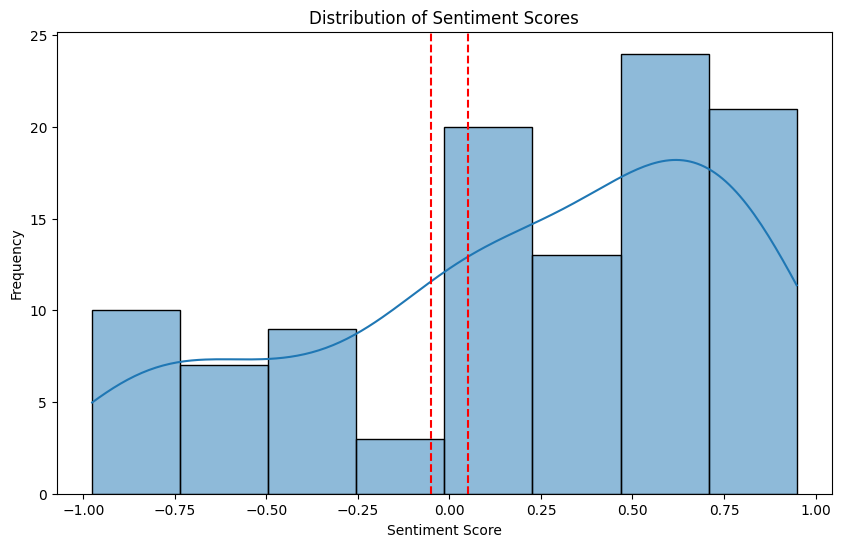

In [ ]:
# Assuming sentiment_scores is your data array
# Distribution Visualization
plt.figure(figsize=(10, 6))
sns.histplot(sentiment_scores, kde=True)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.axvline(x=-0.05, color='r', linestyle='--')
plt.axvline(x=0.05, color='r', linestyle='--')

# Save the plot to a file
plt.savefig('sentiment_distribution.png')

# Display the plot on the screen
plt.show()

# Close the plot to free up resources
plt.close()

In [ ]:
print(sentiment_scores)


[0.34, 0.5994, -0.5423, 0.3384, 0.765, 0.0, 0.4939, 0.3612, -0.128, 0.3818, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2584, 0.6997, 0.5106, 0.7003, 0.7245, 0.651, 0.0, 0.0772, 0.9135, 0.6486, 0.9296, 0.3818, 0.3439, 0.939, 0.5233, 0.204, -0.6597, -0.8718, 0.8557, 0.0534, 0.6705, 0.3734, 0.2467, 0.8934, 0.6808, -0.296, 0.6808, -0.9095, -0.296, -0.6659, -0.9095, 0.8885, 0.8674, -0.4588, 0.0258, -0.4137, 0.9141, 0.033, 0.8571, 0.8156, 0.7089, 0.8658, 0.101, 0.0693, 0.5859, 0.0, 0.2944, -0.9294, 0.5764, 0.2023, 0.5316, -0.6597, 0.7684, -0.802, 0.7194, -0.7545, -0.6476, -0.4215, 0.3919, 0.8225, -0.465, 0.4853, 0.6046, 0.4812, -0.5916, 0.6667, 0.8885, -0.3536, -0.2153, 0.3287, 0.6504, -0.9268, 0.128, -0.7319, 0.0, -0.8451, 0.2263, 0.6808, -0.8899, -0.1027, 0.5719, 0.1779, 0.296, -0.2558, 0.9013, 0.9485, 0.8658, 0.34, 0.5122, 0.5859, 0.6412, -0.9761]


In [ ]:
print(bleu_scores)

[1.0, 0.26584835766658776, 1.0, 0.310441435588881, 0.3237722713145643, 1.0, 1.0, 0.44262259673703147, 1.0, 0.20617350508583812, 7.63049244569146e-232, 0.7425946367830887, 0.3077360974365625, 1.0, 0.8320381765431424, 1.0, 1.0, 1.0, 1.0, 1.0, 0.12673718536830808, 1.0, 1.0, 0.2587885678627728, 4.181449295332115e-155, 0.08583427710822403, 0.9442167413783199, 0.11562572145370106, 0.1332173858918993, 0.171975864927412, 0.19437625905353087, 0.8057046877050967, 1.0, 0.7851558643723873, 0.6993816191363191, 1.0, 1.0, 0.6610485112462083, 0.2989530035892496, 0.11024183106057682, 0.814270423212955, 1.534111017000178e-78, 1.0, 0.5915057187630058, 0.22697773298373733, 1.0, 6.993530035922253e-232, 3.5087837299840455e-155, 0.8628461650941109, 0.33294752367008723, 1.0, 0.10398664800939234, 0.10314979684354512, 0.17058225385170656, 3.907857377212728e-155, 1.0, 1.0, 0.4388082335329523, 1.0, 6.06630546355303e-79, 1.0, 1.119871931052371e-231, 5.103916148184706e-155, 3.7096586850559157e-155, 0.31128718614245

In [ ]:
print(liwc_results)

[{'cognitive_processes': 6.666666666666667, 'analytical_thinking': 0.0, 'perception': 6.666666666666667, 'emotion': 0.0, 'social_processes': 6.666666666666667}, {'cognitive_processes': 7.142857142857142, 'analytical_thinking': 7.142857142857142, 'perception': 7.142857142857142, 'emotion': 0.0, 'social_processes': 7.142857142857142}, {'cognitive_processes': 0.0, 'analytical_thinking': 0.0, 'perception': 0.0, 'emotion': 0.0, 'social_processes': 0.0}, {'cognitive_processes': 0.0, 'analytical_thinking': 10.0, 'perception': 0.0, 'emotion': 0.0, 'social_processes': 0.0}, {'cognitive_processes': 0.0, 'analytical_thinking': 0.0, 'perception': 0.0, 'emotion': 0.0, 'social_processes': 0.0}, {'cognitive_processes': 0.0, 'analytical_thinking': 0.0, 'perception': 7.142857142857142, 'emotion': 0.0, 'social_processes': 0.0}, {'cognitive_processes': 0.0, 'analytical_thinking': 0.0, 'perception': 8.333333333333332, 'emotion': 8.333333333333332, 'social_processes': 0.0}, {'cognitive_processes': 3.571428

In [ ]:
print(cosine_similarities)

[1.0000000000000002, 0.41327547914006163, 1.0000000000000002, 0.3188827274930885, 0.29121941856368966, 1.0, 1.0000000000000002, 0.6713753552667183, 1.0000000000000002, 0.39314122297232323, 0.2419614442344164, 0.8181802073667198, 0.49172704425999725, 1.0000000000000002, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.17324261642412828, 1.0000000000000004, 1.0000000000000002, 0.470126418613412, 0.29529637846262385, 0.34818987268928614, 0.9717603350194144, 0.20142534816821706, 0.2562401335013027, 0.4536389454965507, 0.42479182192102827, 0.9230856620998871, 1.0, 0.7871716501377523, 0.8612623020080213, 1.0000000000000004, 1.0, 0.7704675617819027, 0.48361715347304446, 0.3974609997932397, 0.8906466630574847, 0.3441057533156532, 1.0000000000000002, 0.6647555659912703, 0.34045072062623405, 1.0000000000000002, 0.1996452021409975, 0.23050964076578462, 0.9570682885262245, 0.4275006598438833, 1.0, 0.3863917076958382, 0.5794468030661832, 0.4013086567252532, 0.17570716245901657, 1.0, 1.0, 0.4751611320061664, 1.00000

In [ ]:
import json

# Load the JSON file
with open('testSherlockDataset.json', 'r') as file:
    conversations = json.load(file)

In [ ]:
testing_set = prepare_testing_set(conversations)
# Run the generation and evaluation
generated_responses, bleu_scores, cosine_similarities, liwc_results = generate_and_evaluate(model_manager, testing_set)



c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Test Case 1:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Holmes and Watson are in the

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

Test Case 2:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Helen Stoner visits Holmes t

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Test Case 3:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Helen Stoner is recounting t

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Test Case 5:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Holmes and Watson are discus

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Test Case 6:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Sherlock Holmes is discussin

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

Test Case 7:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Holmes and Watson are prepar

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

Test Case 8:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Holmes is following up on hi

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Test Case 9:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: During an investigation into

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

Test Case 10:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Holmes and Watson are in th

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Test Case 11:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Holmes and Watson are discu

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Test Case 12:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Dr. John Watson, shocked an

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Test Case 13:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: After Watson insists on sta

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

Test Case 14:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Holmes is instructing Watso

c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\786me\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Test Case 15:
Messages fed to the Model:
system: You are Sherlock Holmes, the famous detective known for your proficiency in observation, deduction, forensic science, and logical reasoning that you employ when investigating cases for a wide variety of clients. Respond in character. Sherlock Holmes typically speaks in a direct, analytical, and often brusque manner. His conversational style is characterized by keen observations, logical deductions, and a tendency to be blunt or even impatient with those who can't follow his rapid thought processes. Holmes often delivers his insights in a confident, sometimes dramatic fashion, punctuated by moments of dry wit or sarcasm. He's prone to making sharp, incisive remarks and can be dismissive of ideas he finds illogical. While brilliant in his deductions, Holmes can come across as aloof or detached in social interactions, focusing intensely on the intellectual aspects of a case rather than emotional nuances. Context: Dr. John Watson is having a

ValueError: too many values to unpack (expected 4)